In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [ ]:
EPOCHS = 125
LR = 5e-5
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [3]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
feature_extractor = models.Classifier(in_shape=IN_SHAPE*N_MAG*MAGNIFICATION, in_channels=1).to(device)
truncated_weights = {}
for key,value in torch.load('Feature_weights_3.pt',weights_only=True).items():
    if not key.startswith('fc2'):
        truncated_weights[key] = value
feature_extractor.load_state_dict(truncated_weights)
feature_extractor.eval()
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, feature_extractor=feature_extractor, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.149425e6
Discriminator network 1 parameters: 0.051121e6
Discriminator network 2 parameters: 0.026545e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


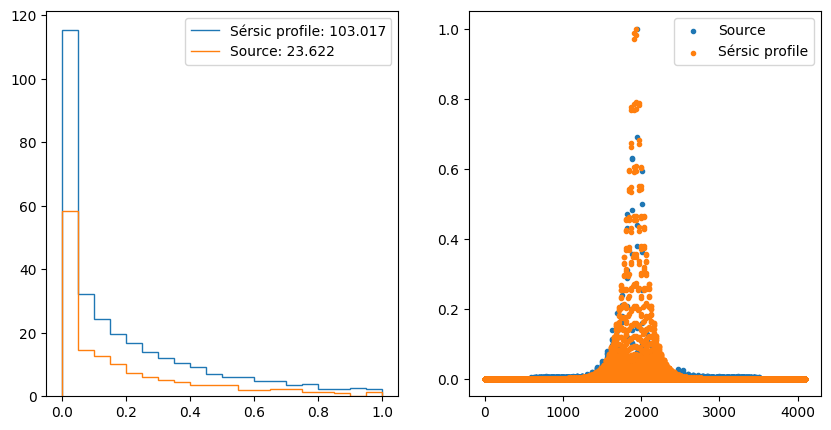

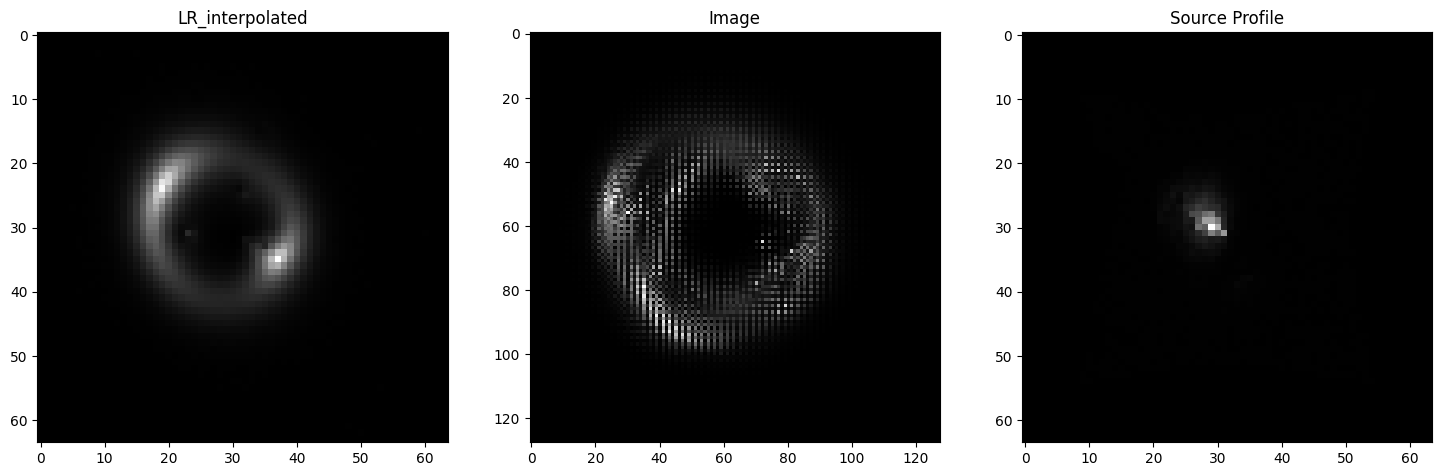

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != []:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 1/125: 0.06499737445447666 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:06<00:00, 33.34it/s]


Validation at epoch 1/125: 0.06461392962099874 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [00:52<00:00, 15.61it/s]


Training at epoch 2/125: 0.05922367846976747 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 32.30it/s]


Validation at epoch 2/125: 0.05824766429734654 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [00:52<00:00, 15.52it/s]


Training at epoch 3/125: 0.0567724835424337 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:06<00:00, 33.15it/s]


Validation at epoch 3/125: 0.05672263307496905 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [00:53<00:00, 15.37it/s]


Training at epoch 4/125: 0.056166045611391 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 32.42it/s]


Validation at epoch 4/125: 0.05646400075627254 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [00:52<00:00, 15.54it/s]


Training at epoch 5/125: 0.055839631551826446 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 32.46it/s]


Validation at epoch 5/125: 0.05675761637679649 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [00:52<00:00, 15.42it/s]


Training at epoch 6/125: 0.05525360391252702 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 33.07it/s]


Validation at epoch 6/125: 0.05516483461428388 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [00:52<00:00, 15.45it/s]


Training at epoch 7/125: 0.05431193609204937 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 31.98it/s]


Validation at epoch 7/125: 0.05415744640534589 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 8/125: 0.05305257533030931 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 32.36it/s]


Validation at epoch 8/125: 0.052517298009821814 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [00:52<00:00, 15.54it/s]


Training at epoch 9/125: 0.0486651653607659 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 32.77it/s]


Validation at epoch 9/125: 0.028051149508660184 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 10/125: 0.01627379144637791 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 32.63it/s]


Validation at epoch 10/125: 0.011342674037259 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [00:52<00:00, 15.43it/s]


Training at epoch 11/125: 0.012134373563515276 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 33.36it/s]


Validation at epoch 11/125: 0.01287387873904378 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [00:52<00:00, 15.44it/s]


Training at epoch 12/125: 0.010887183907542232 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 33.04it/s]


Validation at epoch 12/125: 0.009465562517517337 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [00:52<00:00, 15.44it/s]


Training at epoch 13/125: 0.010504311696493851 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 32.70it/s]


Validation at epoch 13/125: 0.009400550260062458 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 14/125: 0.010005490663780958 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 32.26it/s]


Validation at epoch 14/125: 0.009671869183269639 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 15/125: 0.009816529426162185 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 32.48it/s]


Validation at epoch 15/125: 0.008596667289441706 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 16/125: 0.009236167315690432 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 32.67it/s]


Validation at epoch 16/125: 0.0077123032704762675 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [00:52<00:00, 15.57it/s]


Training at epoch 17/125: 0.009245564716562226 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 33.00it/s]


Validation at epoch 17/125: 0.009184262133203445 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [00:52<00:00, 15.45it/s]


Training at epoch 18/125: 0.008654450860751027 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:06<00:00, 33.09it/s]


Validation at epoch 18/125: 0.008963232307567022 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [00:52<00:00, 15.56it/s]


Training at epoch 19/125: 0.008161371556685908 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 32.20it/s]


Validation at epoch 19/125: 0.007367197544012657 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [00:52<00:00, 15.57it/s]


Training at epoch 20/125: 0.008307201906527374 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 32.87it/s]


Validation at epoch 20/125: 0.008117544803741005 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 21/125: 0.007839801802879711 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 33.24it/s]


Validation at epoch 21/125: 0.007960569811414233 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 22/125: 0.007566435093073832 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 32.77it/s]


Validation at epoch 22/125: 0.006734562164638191 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 23/125: 0.007357319426898589 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:06<00:00, 32.58it/s]


Validation at epoch 23/125: 0.007503097682880859 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [00:52<00:00, 15.40it/s]


Training at epoch 24/125: 0.0072087871918555205 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 32.86it/s]


Validation at epoch 24/125: 0.006568449591035389 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 25/125: 0.007267631006863096 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 32.56it/s]


Validation at epoch 25/125: 0.006856764591979229 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 26/125: 0.007036836374169854 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 32.30it/s]


Validation at epoch 26/125: 0.006499582543791106 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 27/125: 0.007025097136148344 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 33.21it/s]


Validation at epoch 27/125: 0.006376953097630986 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 28/125: 0.007340465048008471 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 32.21it/s]


Validation at epoch 28/125: 0.006943677911562297 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 29/125: 0.0070394976221495225 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:06<00:00, 32.88it/s]


Validation at epoch 29/125: 0.006361180560334641 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [00:52<00:00, 15.41it/s]


Training at epoch 30/125: 0.006999637519851711 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 32.38it/s]


Validation at epoch 30/125: 0.00634299180477255 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 31/125: 0.0068668415209257915 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 32.50it/s]


Validation at epoch 31/125: 0.006946359602842873 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 32/125: 0.007921646615631842 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 33.02it/s]


Validation at epoch 32/125: 0.006693121975153118 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [00:52<00:00, 15.59it/s]


Training at epoch 33/125: 0.007224951106050581 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 32.61it/s]


Validation at epoch 33/125: 0.006432859751500882 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [00:52<00:00, 15.49it/s]


Training at epoch 34/125: 0.006788063060786739 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 32.02it/s]


Validation at epoch 34/125: 0.00626585092287118 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 35/125: 0.006591138471455505 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 32.53it/s]


Validation at epoch 35/125: 0.006227833509910852 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [00:52<00:00, 15.44it/s]


Training at epoch 36/125: 0.006651317050044799 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 33.66it/s]


Validation at epoch 36/125: 0.006158266746948071 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 37/125: 0.006868841792239953 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 33.47it/s]


Validation at epoch 37/125: 0.006188735888452571 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 38/125: 0.006524070012400282 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 32.62it/s]


Validation at epoch 38/125: 0.006161152443382889 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 39/125: 0.0067116328422094276 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 33.15it/s]


Validation at epoch 39/125: 0.006317268893540399 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [00:52<00:00, 15.59it/s]


Training at epoch 40/125: 0.006708675215657637 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 40/125: 0.0062367205786822335 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 41/125: 0.0067261478363755435 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 32.83it/s]


Validation at epoch 41/125: 0.006653913004864828 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 42/125: 0.006473869455244401 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 32.65it/s]


Validation at epoch 42/125: 0.006047671042181842 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 43/125: 0.0066910444816754774 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 33.03it/s]


Validation at epoch 43/125: 0.0060852332466953055 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [00:52<00:00, 15.59it/s]


Training at epoch 44/125: 0.006475058253415103 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 32.46it/s]


Validation at epoch 44/125: 0.005919654385412714 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 45/125: 0.007180616199369907 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 32.23it/s]


Validation at epoch 45/125: 0.00635132640280633 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 46/125: 0.007066304249604525 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 32.98it/s]


Validation at epoch 46/125: 0.006772196164592078 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [00:52<00:00, 15.49it/s]


Training at epoch 47/125: 0.006463781357417568 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 32.73it/s]


Validation at epoch 47/125: 0.0062100338012290495 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [00:52<00:00, 15.52it/s]


Training at epoch 48/125: 0.006463322762226431 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 33.20it/s]


Validation at epoch 48/125: 0.00586403199921216 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 49/125: 0.006505809144394281 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 32.57it/s]


Validation at epoch 49/125: 0.008267270437071976 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 50/125: 0.0070089777723564214 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 32.48it/s]


Validation at epoch 50/125: 0.006378207521800719 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [00:52<00:00, 15.59it/s]


Training at epoch 51/125: 0.006492658247189669 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 33.51it/s]


Validation at epoch 51/125: 0.00593978750383066 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 52/125: 0.006388783914849673 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 33.22it/s]


Validation at epoch 52/125: 0.005965036991898052 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [00:52<00:00, 15.40it/s]


Training at epoch 53/125: 0.006361012831678403 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 32.30it/s]


Validation at epoch 53/125: 0.0061219254297183775 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [00:53<00:00, 15.32it/s]


Training at epoch 54/125: 0.006493078875435316 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 33.09it/s]


Validation at epoch 54/125: 0.006208464699453793 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [00:52<00:00, 15.42it/s]


Training at epoch 55/125: 0.006626367235559668 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 32.72it/s]


Validation at epoch 55/125: 0.0060446023818062095 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 56/125: 0.006496899949150462 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 33.37it/s]


Validation at epoch 56/125: 0.006559664569852198 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 57/125: 0.00686414277993654 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 33.35it/s]


Validation at epoch 57/125: 0.00828127323549387 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 58/125: 0.007151130680166021 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 33.39it/s]


Validation at epoch 58/125: 0.006413958449853703 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [00:52<00:00, 15.54it/s]


Training at epoch 59/125: 0.00650466209224439 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 33.08it/s]


Validation at epoch 59/125: 0.00618117514572006 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 60/125: 0.006501538098068432 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 32.96it/s]


Validation at epoch 60/125: 0.0066022692171471 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 61/125: 0.006540416442565437 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 32.91it/s]


Validation at epoch 61/125: 0.006073445349922586 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 62/125: 0.006329679151331577 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 33.50it/s]


Validation at epoch 62/125: 0.006175412381280158 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [00:52<00:00, 15.61it/s]


Training at epoch 63/125: 0.006232227043701821 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 33.59it/s]


Validation at epoch 63/125: 0.00617172333466656 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 64/125: 0.006409677932656361 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 33.41it/s]


Validation at epoch 64/125: 0.006305936316137234 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [00:52<00:00, 15.61it/s]


Training at epoch 65/125: 0.007179407100992131 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 33.24it/s]


Validation at epoch 65/125: 0.006179067750053946 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 66/125: 0.006258257509804988 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 33.19it/s]


Validation at epoch 66/125: 0.006225903858185299 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 67/125: 0.0061823121964242125 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 33.46it/s]


Validation at epoch 67/125: 0.0060175619735530865 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 68/125: 0.006165908694931525 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 33.20it/s]


Validation at epoch 68/125: 0.005851654740884745 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [00:53<00:00, 15.33it/s]


Training at epoch 69/125: 0.006405580192792923 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 32.70it/s]


Validation at epoch 69/125: 0.005989696105625983 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 70/125: 0.006200510418435156 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 70/125: 0.005957643189593035 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [00:52<00:00, 15.52it/s]


Training at epoch 71/125: 0.006560736496598396 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 32.23it/s]


Validation at epoch 71/125: 0.005892363355729579 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [00:52<00:00, 15.43it/s]


Training at epoch 72/125: 0.0063590455837958665 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 33.26it/s]


Validation at epoch 72/125: 0.0076117670681674545 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [00:52<00:00, 15.63it/s]


Training at epoch 73/125: 0.006459334650500358 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 32.42it/s]


Validation at epoch 73/125: 0.006772288951241554 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 74/125: 0.007090715527524214 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 31.50it/s]


Validation at epoch 74/125: 0.006254031423761226 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [00:53<00:00, 15.38it/s]


Training at epoch 75/125: 0.006369458688234719 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 33.10it/s]


Validation at epoch 75/125: 0.006183248117832036 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [00:52<00:00, 15.40it/s]


Training at epoch 76/125: 0.006366990434174773 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 32.82it/s]


Validation at epoch 76/125: 0.006035055298650382 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [00:53<00:00, 15.40it/s]


Training at epoch 77/125: 0.006199767715645744 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 32.47it/s]


Validation at epoch 77/125: 0.00608239283168337 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 78/125: 0.00633721825379682 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 32.85it/s]


Validation at epoch 78/125: 0.0061197028070655145 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [00:52<00:00, 15.45it/s]


Training at epoch 79/125: 0.006158961490904866 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 33.25it/s]


Validation at epoch 79/125: 0.0058678566646823815 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 80/125: 0.006214568419690134 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 32.15it/s]


Validation at epoch 80/125: 0.006124447399462738 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [00:52<00:00, 15.42it/s]


Training at epoch 81/125: 0.006475254652054989 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 32.58it/s]


Validation at epoch 81/125: 0.0062259558976888105 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 82/125: 0.0065518590290950815 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 32.70it/s]


Validation at epoch 82/125: 0.0060047001320972584 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [00:52<00:00, 15.40it/s]


Training at epoch 83/125: 0.006724153553317165 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 32.14it/s]


Validation at epoch 83/125: 0.006152768074660379 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 84/125: 0.006269384898569472 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 32.16it/s]


Validation at epoch 84/125: 0.006231578070369056 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [00:53<00:00, 15.39it/s]


Training at epoch 85/125: 0.0061210231638944915 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 33.06it/s]


Validation at epoch 85/125: 0.005964131566881905 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [00:52<00:00, 15.46it/s]


Training at epoch 86/125: 0.00628981262992716 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 32.62it/s]


Validation at epoch 86/125: 0.0060165546001015036 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [00:52<00:00, 15.46it/s]


Training at epoch 87/125: 0.006134713875379769 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 32.91it/s]


Validation at epoch 87/125: 0.005921965003140299 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [00:52<00:00, 15.50it/s]


Training at epoch 88/125: 0.0063691676857392755 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 32.35it/s]


Validation at epoch 88/125: 0.005992174561434498 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [00:52<00:00, 15.46it/s]


Training at epoch 89/125: 0.006067505530190115 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 32.19it/s]


Validation at epoch 89/125: 0.006024145772030084 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [00:52<00:00, 15.53it/s]


Training at epoch 90/125: 0.0062164846223073675 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 32.43it/s]


Validation at epoch 90/125: 0.0063303219112105374 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [00:52<00:00, 15.45it/s]


Training at epoch 91/125: 0.006264224423776955 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 33.17it/s]


Validation at epoch 91/125: 0.006287486523183807 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [00:52<00:00, 15.43it/s]


Training at epoch 92/125: 0.006105794661647557 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 32.45it/s]


Validation at epoch 92/125: 0.005910381380732254 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 93/125: 0.006278093327601514 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 31.93it/s]


Validation at epoch 93/125: 0.005914245225379571 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 94/125: 0.006098663925156728 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 94/125: 0.0056035012970039365 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [00:52<00:00, 15.42it/s]


Training at epoch 95/125: 0.006111079318917986 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 32.73it/s]


Validation at epoch 95/125: 0.005671567412540683 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [00:52<00:00, 15.44it/s]


Training at epoch 96/125: 0.0060095127455675615 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 32.63it/s]


Validation at epoch 96/125: 0.005645607512526433 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [00:52<00:00, 15.59it/s]


Training at epoch 97/125: 0.006319535058448274 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 32.89it/s]


Validation at epoch 97/125: 0.006321122860005262 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [00:52<00:00, 15.47it/s]


Training at epoch 98/125: 0.006132988597599642 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 32.20it/s]


Validation at epoch 98/125: 0.005845466568037712 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [00:52<00:00, 15.44it/s]


Training at epoch 99/125: 0.006052966844792678 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 32.61it/s]


Validation at epoch 99/125: 0.005681467277206727 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [00:52<00:00, 15.54it/s]


Training at epoch 100/125: 0.006014895618136506 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 32.46it/s]


Validation at epoch 100/125: 0.005712106022852537 at LR=5e-05


Training epoch 101: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 101/125: 0.00608376005687865 at LR=5e-05


Validation epoch 101: 100%|██████████| 204/204 [00:06<00:00, 32.66it/s]


Validation at epoch 101/125: 0.005901228761621158 at LR=5e-05


Training epoch 102: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 102/125: 0.006031379888037348 at LR=5e-05


Validation epoch 102: 100%|██████████| 204/204 [00:06<00:00, 33.07it/s]


Validation at epoch 102/125: 0.005786744001442475 at LR=5e-05


Training epoch 103: 100%|██████████| 816/816 [00:53<00:00, 15.39it/s]


Training at epoch 103/125: 0.006120693719376326 at LR=5e-05


Validation epoch 103: 100%|██████████| 204/204 [00:06<00:00, 33.49it/s]


Validation at epoch 103/125: 0.005907018648548389 at LR=5e-05


Training epoch 104: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 104/125: 0.006051385062021961 at LR=5e-05


Validation epoch 104: 100%|██████████| 204/204 [00:06<00:00, 32.55it/s]


Validation at epoch 104/125: 0.0056606470015157905 at LR=5e-05


Training epoch 105: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 105/125: 0.00596152934746237 at LR=5e-05


Validation epoch 105: 100%|██████████| 204/204 [00:06<00:00, 32.08it/s]


Validation at epoch 105/125: 0.005869563442555612 at LR=5e-05


Training epoch 106: 100%|██████████| 816/816 [00:53<00:00, 15.32it/s]


Training at epoch 106/125: 0.0060277299989156385 at LR=5e-05


Validation epoch 106: 100%|██████████| 204/204 [00:06<00:00, 32.72it/s]


Validation at epoch 106/125: 0.005936966879708765 at LR=5e-05


Training epoch 107: 100%|██████████| 816/816 [00:52<00:00, 15.41it/s]


Training at epoch 107/125: 0.005912201119274102 at LR=5e-05


Validation epoch 107: 100%|██████████| 204/204 [00:06<00:00, 31.15it/s]


Validation at epoch 107/125: 0.005757731863459591 at LR=5e-05


Training epoch 108: 100%|██████████| 816/816 [00:52<00:00, 15.46it/s]


Training at epoch 108/125: 0.006024576900124564 at LR=5e-05


Validation epoch 108: 100%|██████████| 204/204 [00:06<00:00, 33.50it/s]


Validation at epoch 108/125: 0.005916811758010333 at LR=5e-05


Training epoch 109: 100%|██████████| 816/816 [00:52<00:00, 15.60it/s]


Training at epoch 109/125: 0.006510143608323358 at LR=5e-05


Validation epoch 109: 100%|██████████| 204/204 [00:06<00:00, 32.64it/s]


Validation at epoch 109/125: 0.006044971631947157 at LR=5e-05


Training epoch 110: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 110/125: 0.005972272959850528 at LR=5e-05


Validation epoch 110: 100%|██████████| 204/204 [00:06<00:00, 32.91it/s]


Validation at epoch 110/125: 0.005654979842017615 at LR=5e-05


Training epoch 111: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 111/125: 0.005967688445654108 at LR=5e-05


Validation epoch 111: 100%|██████████| 204/204 [00:06<00:00, 32.83it/s]


Validation at epoch 111/125: 0.00574514270627725 at LR=5e-05


Training epoch 112: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 112/125: 0.005935749619703867 at LR=5e-05


Validation epoch 112: 100%|██████████| 204/204 [00:06<00:00, 32.61it/s]


Validation at epoch 112/125: 0.00582450762800256 at LR=5e-05


Training epoch 113: 100%|██████████| 816/816 [00:52<00:00, 15.49it/s]


Training at epoch 113/125: 0.0058889700182286715 at LR=5e-05


Validation epoch 113: 100%|██████████| 204/204 [00:06<00:00, 33.54it/s]


Validation at epoch 113/125: 0.006028923997541379 at LR=5e-05


Training epoch 114: 100%|██████████| 816/816 [00:52<00:00, 15.63it/s]


Training at epoch 114/125: 0.006232687364792903 at LR=5e-05


Validation epoch 114: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 114/125: 0.006599328249684927 at LR=5e-05


Training epoch 115: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 115/125: 0.006109595081558356 at LR=5e-05


Validation epoch 115: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 115/125: 0.005934429696151033 at LR=5e-05


Training epoch 116: 100%|██████████| 816/816 [00:52<00:00, 15.48it/s]


Training at epoch 116/125: 0.005943923517371135 at LR=5e-05


Validation epoch 116: 100%|██████████| 204/204 [00:06<00:00, 33.00it/s]


Validation at epoch 116/125: 0.005747561555943 at LR=5e-05


Training epoch 117: 100%|██████████| 816/816 [00:52<00:00, 15.58it/s]


Training at epoch 117/125: 0.0059684039273740965 at LR=5e-05


Validation epoch 117: 100%|██████████| 204/204 [00:06<00:00, 32.37it/s]


Validation at epoch 117/125: 0.005766550738532233 at LR=5e-05


Training epoch 118: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 118/125: 0.00593399789467381 at LR=5e-05


Validation epoch 118: 100%|██████████| 204/204 [00:06<00:00, 31.86it/s]


Validation at epoch 118/125: 0.005993910609771881 at LR=5e-05


Training epoch 119: 100%|██████████| 816/816 [00:52<00:00, 15.55it/s]


Training at epoch 119/125: 0.00589019115860163 at LR=5e-05


Validation epoch 119: 100%|██████████| 204/204 [00:06<00:00, 33.08it/s]


Validation at epoch 119/125: 0.005635619925063414 at LR=5e-05


Training epoch 120: 100%|██████████| 816/816 [00:52<00:00, 15.51it/s]


Training at epoch 120/125: 0.0061901551877478304 at LR=5e-05


Validation epoch 120: 100%|██████████| 204/204 [00:06<00:00, 33.48it/s]


Validation at epoch 120/125: 0.006234844646065076 at LR=5e-05


Training epoch 121: 100%|██████████| 816/816 [00:52<00:00, 15.61it/s]


Training at epoch 121/125: 0.0058763408469887654 at LR=5e-05


Validation epoch 121: 100%|██████████| 204/204 [00:06<00:00, 32.78it/s]


Validation at epoch 121/125: 0.0063875414721848095 at LR=5e-05


Training epoch 122: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 122/125: 0.00608426999286737 at LR=5e-05


Validation epoch 122: 100%|██████████| 204/204 [00:06<00:00, 33.50it/s]


Validation at epoch 122/125: 0.005650950143628472 at LR=5e-05


Training epoch 123: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 123/125: 0.005937235427885681 at LR=5e-05


Validation epoch 123: 100%|██████████| 204/204 [00:06<00:00, 32.76it/s]


Validation at epoch 123/125: 0.005671110274681055 at LR=5e-05


Training epoch 124: 100%|██████████| 816/816 [00:52<00:00, 15.65it/s]


Training at epoch 124/125: 0.005824457624340521 at LR=5e-05


Validation epoch 124: 100%|██████████| 204/204 [00:06<00:00, 32.35it/s]


Validation at epoch 124/125: 0.005730169995170881 at LR=5e-05


Training epoch 125: 100%|██████████| 816/816 [00:52<00:00, 15.54it/s]


Training at epoch 125/125: 0.005893133714148551 at LR=5e-05


Validation epoch 125: 100%|██████████| 204/204 [00:06<00:00, 32.58it/s]

Validation at epoch 125/125: 0.005694207060764266 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

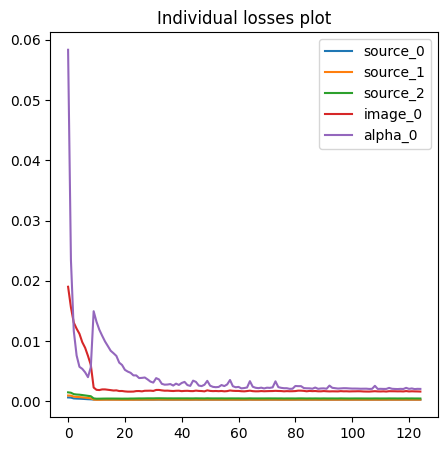

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

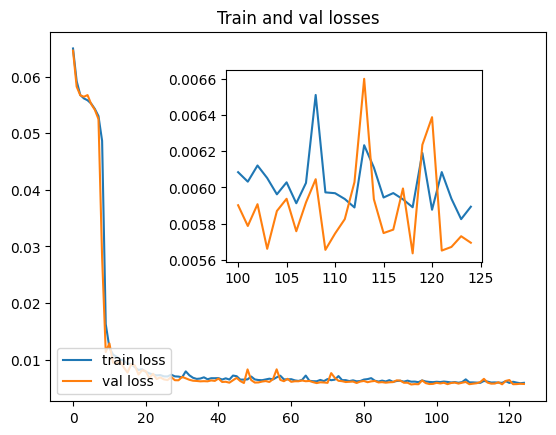

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.007317503501076763


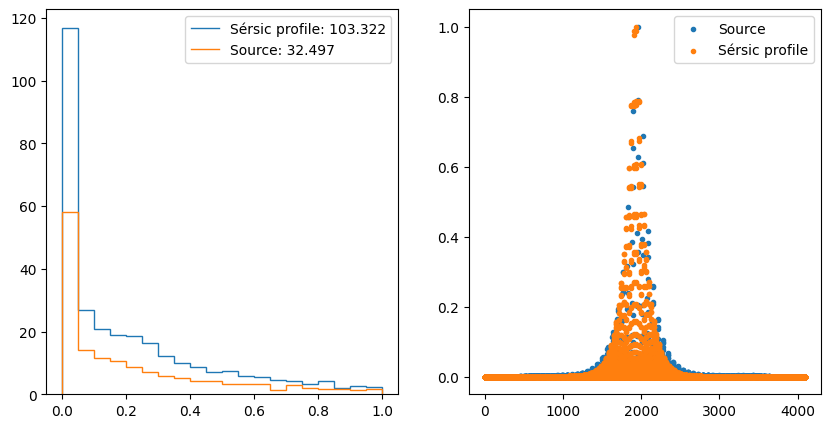

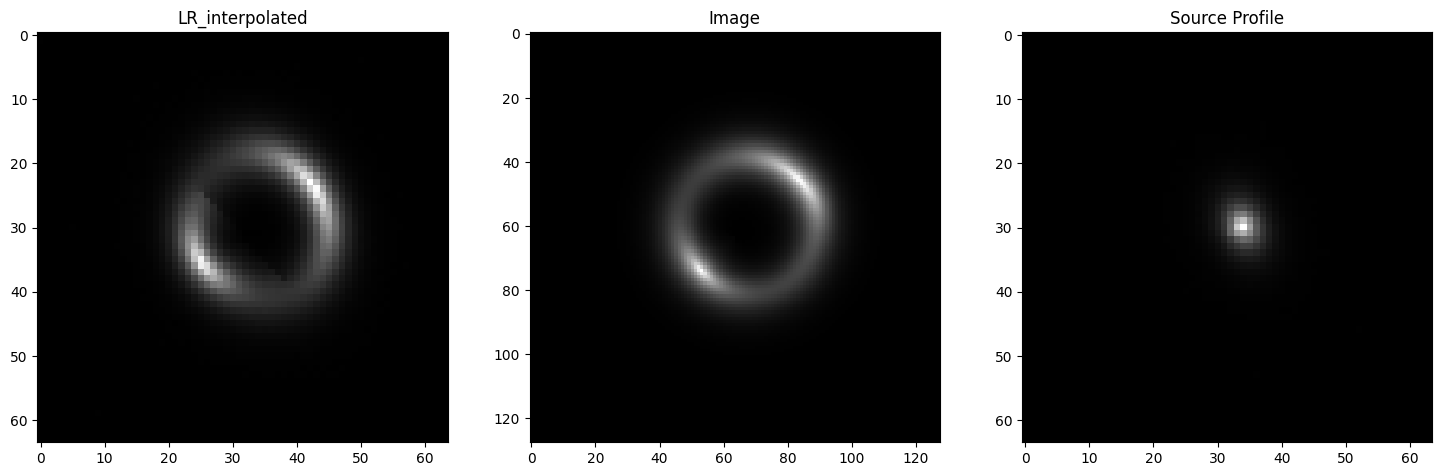

In [19]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_3.pt')